In [4]:
from pathlib import Path

import healpix as hp
import numpy as np
import xarray as xr

import easygems.healpix as egh
import easygems.remap as egr


In [1]:

ds = xr.open_dataset(
    "https://eerie.cloud.dkrz.de/datasets/icon-esm-er.eerie-control-1950.v20240618.atmos.native.2d_6h_inst/kerchunk",
    engine="zarr",
    chunks={},
)
ds

<xarray.Dataset> Size: 8TB
Dimensions:             (ncells: 5242880, height: 1, height_2: 1, time: 73051)
Coordinates:
    cell_sea_land_mask  (ncells) float64 42MB dask.array<chunksize=(5242880,), meta=np.ndarray>
  * height              (height) float64 8B 10.0
  * height_2            (height_2) float64 8B 2.0
    lat                 (ncells) float64 42MB dask.array<chunksize=(5242880,), meta=np.ndarray>
    lon                 (ncells) float64 42MB dask.array<chunksize=(5242880,), meta=np.ndarray>
  * time                (time) datetime64[ns] 584kB 1991-01-01T05:59:59 ... 2...
Dimensions without coordinates: ncells
Data variables:
    hus2m               (time, height_2, ncells) float32 2TB dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
    psl                 (time, ncells) float32 2TB dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    ts                  (time, ncells) float32 2TB dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    uas                 (time, height, ncells) float32 2TB dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
    vas                 (time, height, ncells) float32 2TB dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
Attributes: (12/31)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           EERIE
    data_specs_version:    01.00.32
    forcing_index:         1
    initialization_index:  1
    license:               EERIE model data produced by MPI-M is licensed und...
    ...                    ...
    parent_activity_id:    EERIE
    sub_experiment_id:     none
    experiment:            coupled control with fixed 1950's forcing (HighRes...
    source:                ICON-ESM-ER (2023): \naerosol: none, prescribed MA...
    institution:           Max Planck Institute for Meteorology, Hamburg 2014...
    sub_experiment:        none

In [2]:
order = zoom = 9
nside = hp.order2nside(order)
npix = hp.nside2npix(nside)

hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=True, nest=True)
hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
hp_lon += 360 / (4 * nside) / 4  # shift quarter-width

In [6]:
weights_path = Path('../icon_to_hp_weights.nc')
if not weights_path.exists():
    weights = egr.compute_weights_delaunay((ds.lon, ds.lat), (hp_lon, hp_lat))
    weights.to_netcdf(weights_path)
else:
    weights = xr.open_dataset(weights_path)

In [7]:
weights

<xarray.Dataset> Size: 116MB
Dimensions:  (tgt_idx: 3145728, tri: 3)
Dimensions without coordinates: tgt_idx, tri
Data variables:
    src_idx  (tgt_idx, tri) int32 38MB ...
    weights  (tgt_idx, tri) float64 75MB ...
    valid    (tgt_idx) bool 3MB ...

<Figure size 640x480 with 0 Axes>

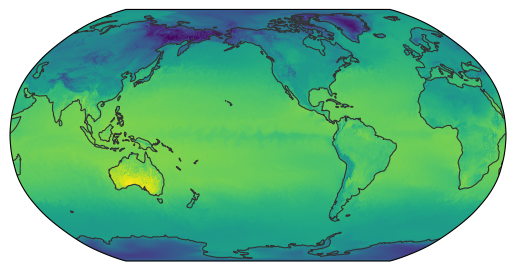

In [8]:
egh.healpix_show(egr.apply_weights(ds.ts.isel(time=0), **weights))

In [1]:
import earthkit

In [2]:
from earthkit.regrid import interpolate
from earthkit.data import from_source

In [3]:
ds = from_source("url",
                 "https://get.ecmwf.int/repository/test-data/earthkit-regrid/examples/O32_multi.grib2")

O32_multi.grib2:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

In [4]:
ds

GRIBReader(/tmp/tmp5ywvg___/url-7fa3a00c6c3a64bf2a6f1b2fa608f760cd2e9120e1c107d762a4d174940767ba.grib2)

In [6]:
a = np.arange(360 * 180).reshape(360, 180)

In [7]:
interpolate(a, {'grid': [1, 1]}, {'grid': 'H512', 'ordering': 'nested'})

ValueError: No matrix found! in_grid={'grid': [1, 1]} out_grid={'grid': 'H512', 'ordering': 'nested'} method='linear'

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import earth2grid

/home/markmuetz/anaconda3/envs/wcrp_hackathon_env/lib/python3.12/site-packages/earth2grid/healpix.py:60: UserWarning: healpixpad_cuda module not available, reverting to CPU for all padding routines
  warnings.warn("healpixpad_cuda module not available, reverting to CPU for all padding routines")


In [9]:
level = 6
hpx = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY())
src = earth2grid.latlon.equiangular_lat_lon_grid(32, 64)
regrid = earth2grid.get_regridder(src, hpx)

In [10]:
z = np.cos(np.deg2rad(src.lat)) * np.cos(np.deg2rad(src.lon))

In [11]:
z_torch = torch.as_tensor(z)

In [12]:
z_hpx = regrid(z_torch)

Text(0.5, 1.0, 'Healpix')

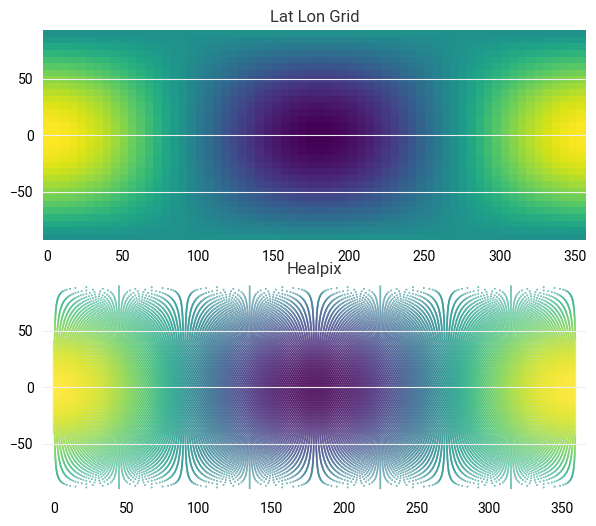

In [13]:
fig, (a, b) = plt.subplots(2, 1)
a.pcolormesh(src.lon, src.lat, z)
a.set_title("Lat Lon Grid")

b.scatter(hpx.lon, hpx.lat, c=z_hpx, s=0.1)
b.set_title("Healpix")

In [33]:
# level is the resolution
level = 10
hpx = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY())
src = earth2grid.latlon.equiangular_lat_lon_grid(int(1.5 * 2560), 2 * 2560)
regrid = earth2grid.get_regridder(src, hpx)


z = np.cos(np.deg2rad(src.lat)) * np.cos(np.deg2rad(src.lon))


z_torch = torch.as_tensor(z)
z_hpx = regrid(z_torch)

In [25]:
z.shape

(5120, 3840)

In [31]:
z_hpx.numpy().shape

(12582912,)

In [32]:
src.lat

array([[ 90.        ],
       [ 89.96483688],
       [ 89.92967376],
       ...,
       [-89.92967376],
       [-89.96483688],
       [-90.        ]])

In [16]:

fig, (a, b) = plt.subplots(2, 1)
a.pcolormesh(src.lon, src.lat, z)
a.set_title("Lat Lon Grid")

b.scatter(hpx.lon, hpx.lat, c=z_hpx, s=0.1)
b.set_title("Healpix")

Text(0.5, 1.0, 'Healpix')

Error in callback <function flush_figures at 0x7fb127707100> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [20]:
2 * np.pi * 6400 / (2 * 2560)

7.853981633974483